## Setup

In [1]:
import sys
import os
from pathlib import Path
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
import matplotlib.colors as colors
from datetime import datetime
import ast

import numpy as np
import pandas as pd
import geopandas as gpd
import contextily as ctx
import random
import isuelogit as isl
import glob
import time

from sklearn import preprocessing
from sklearn.impute import SimpleImputer

In [2]:
import tensorflow as tf
tf.config.set_visible_devices([], 'GPU')

In [3]:
# Path management
main_dir = str(Path(os.path.abspath('')).parents[1])
os.chdir(main_dir)
print('main dir:', main_dir)

sys.path.append(os.path.join(main_dir, 'src'))

isl.config.dirs['read_network_data'] = "input/network-data/fresno/"

main dir: /Users/pablo/github/nesuelogit


In [85]:
%load_ext autoreload
%autoreload 2

from pesuelogit.networks import read_OD, load_k_shortest_paths
from pesuelogit.etl import data_curation, add_period_id

# Internal modules
from nesuelogit.models import NESUELOGIT, ODParameters, UtilityParameters, BPR, MLP, KernelConstraint, \
    GenerationParameters, compute_generated_trips, compute_generation_factors, PolynomialLayer, regularization_kfold
from nesuelogit.etl import build_network, get_tensors_by_year
from nesuelogit.visualizations import plot_flow_vs_traveltime, plot_congestion_maps
from nesuelogit.metrics import mse, mape, r2_score,  z2score
from nesuelogit.utils import read_paths

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
# Seed for reproducibility
_SEED = 2023
np.random.seed(_SEED)
random.seed(_SEED)
tf.random.set_seed(_SEED)

In [6]:
# To report global runtime
t0_global = time.time()

In [7]:
# Set timestamp to add in the filenames that are written in disk
ts = datetime.now().strftime('%y%m%d%H%M%S')
print('Timestamp:',ts)

Timestamp: 231201185808


In [57]:
isl.config.dirs['read_network_data']

'input/network-data/fresno/'

## Read nodes and link-specific data

In [58]:
nodes_df = pd.read_csv('./input/network-data/fresno/nodes/fresno-nodes-gis-data.csv')

links_df = pd.read_csv('./input/network-data/fresno/links/fresno-link-specific-data.csv',
                       converters={"link_key": ast.literal_eval, "pems_id": ast.literal_eval})

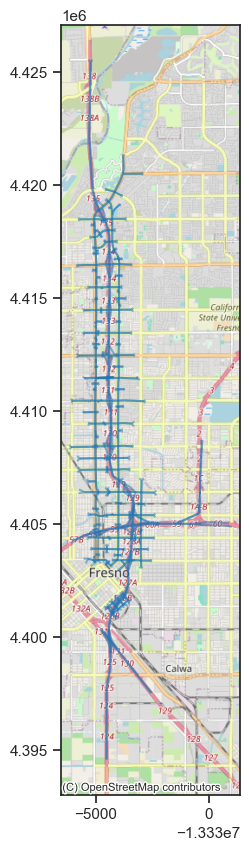

In [66]:
## Display network
links_gdf = gpd.read_file('./input/network-data/fresno/gis/links/fresno-links-gis.shp').set_crs(
        'EPSG:2228')
ax = links_gdf.to_crs(epsg=3857).plot(figsize=(10, 10), alpha=0.5)
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)

## Build Fresno network

In [56]:
network = build_network(links_df=links_df, nodes_df=nodes_df, crs='epsg:4326', key= 'fresno')

KeyError: 0

## Read OD matrix

In [10]:
read_OD(network=network, sparse=True)

q_historic = np.repeat(network.q.flatten()[np.newaxis, :], 6, axis=0)

Matrix Q (1789, 1789) read in 0.0[s] with sparse format
66266.3 trips were loaded among 6970 o-d pairs



## Read paths

In [11]:
read_paths(network=network, update_incidence_matrices=True, filename = 'paths-full-model-fresno.csv')

Paths were read and incidence matrix were built


## Read spatiotemporal data

In [67]:
folderpath = './input/network-data/fresno/links/spatiotemporal-data/'
df = pd.concat([pd.read_csv(file) for file in glob.glob(folderpath + "*link-data*")], axis=0)

df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')

df['link_key'] = pd.Categorical(df['link_key'].apply(ast.literal_eval), list(network.links_dict.keys()))
df['period'] = pd.to_datetime(df['period']).dt.strftime('%Y-%m-%d-%H')

# Select data from Tuesdays to Thursdays
df = df[df['date'].dt.dayofweek.between(1, 3)]

In [68]:
# Add period id for timevarying estimation
period_feature = 'hour'

df = add_period_id(df, period_feature='hour')

period_keys = df[[period_feature,'period_id']].drop_duplicates().reset_index().drop('index',axis =1).sort_values('hour')
print(period_keys)

    hour  period_id
11     6          0
12     7          1
13     8          2
14     9          3
0     10          4
1     11          5
2     12          6
3     13          7
4     14          8
5     15          9
6     16         10
7     17         11
8     18         12
9     19         13
10    20         14


## Data curation

In [69]:
df['tt_ff'] = np.where(df['link_type'] != 'LWRLK', 0,df['length']/df['speed_ref_avg'])
df.loc[(df.link_type == "LWRLK") & (df.speed_ref_avg == 0),'tt_ff'] = float('nan')

df['tt_avg'] = np.where(df['link_type'] != 'LWRLK', 0,df['length']/df['speed_hist_avg'])
df.loc[(df.link_type == "LWRLK") & (df.speed_hist_avg == 0),'tt_avg'] = float('nan')

tt_sd_adj = df.groupby(['period_id','link_key'])[['tt_avg']].std().reset_index().rename(columns = {'tt_avg': 'tt_sd_adj'})

df = df.merge(tt_sd_adj, on = ['period_id','link_key'])

df = data_curation(df)

df['tt_sd'] = df['tt_sd_adj']

In [70]:
# Units of travel time features are converted from hours to minutes
df['tt_sd'] = df['tt_sd']*60
df['tt_avg'] = df['tt_avg']*60
df['tt_ff'] = df['tt_ff']*60

## Node data

In [71]:
nodes_df = nodes_df.rename(columns ={'pop_tract':'population','stops_tract': 'bus_stops','median_inc':'income'})

features_generation = ['population','income', 'bus_stops']

nodes_df = nodes_df[['key','type'] + features_generation]

imp_mean = SimpleImputer(missing_values=np.nan, strategy='mean')
imp_mean.fit(nodes_df[features_generation])
nodes_df[features_generation] = imp_mean.transform(nodes_df[features_generation])

scaler = preprocessing.StandardScaler().fit(nodes_df[features_generation].values)
nodes_df[features_generation] = scaler.transform(nodes_df[features_generation].values)

## Utility function

In [72]:
_FEATURES_Z = ['tt_sd', 'median_inc', 'incidents', 'bus_stops', 'intersections']

## Data processing

In [73]:
n_links = len(network.links)
df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')
df['year'] = df.date.dt.year

In [74]:
# Set free flow travel times
tt_ff_links = df.groupby('link_key')['tt_ff'].min()
for link in network.links:
    network.links_dict[link.key].performance_function.tf = float(tt_ff_links[tt_ff_links.index==link.key].iloc[0])

## EDA

In [75]:
# To check that there is a balanced amount of observations per date
obs_date = df.groupby('date')['hour'].count()

In [76]:
# Stats by date
df.groupby('date')[['speed_sd','speed_avg', 'counts']].mean().assign(total_obs = obs_date)

,speed_sd,speed_avg,counts,total_obs
date,,,,
2019-10-01,1.731787,17.175187,1770.335035,36195
2019-10-02,1.760109,17.169768,1746.651824,36195
2019-10-03,1.754288,17.092304,1785.115209,36195
2019-10-08,1.847060,18.165569,1747.732955,36195
2019-10-09,1.917923,18.137042,1756.834846,36195
2019-10-10,1.830232,18.107925,1793.512340,36195
2019-10-15,1.831527,18.114384,1750.339155,36195
2019-10-16,1.823680,18.162625,1760.170975,36195
2019-10-17,1.832219,18.080860,1775.411385,36195


### Link attributes

In [77]:
df[_FEATURES_Z].describe()

,tt_sd,median_inc,incidents,bus_stops,intersections
count,1.013460e+06,1.013460e+06,1.013460e+06,1.013460e+06,1.013460e+06
mean,1.813680e-02,2.621913e+01,7.441093e-01,1.500207e-01,8.765023e-01
std,2.783112e-02,2.135738e+01,3.193143e+00,4.411927e-01,1.319496e+00
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,1.113761e-02,2.482100e+01,0.000000e+00,0.000000e+00,0.000000e+00
75%,2.548870e-02,4.168100e+01,0.000000e+00,0.000000e+00,1.000000e+00
max,7.459602e-01,1.158930e+02,4.000000e+01,4.000000e+00,9.000000e+00


## Training and validation sets

In [80]:
_DTYPE = tf.float32

X, Y = {}, {}

# Data between 4pm and 5pm to estimate LUE, ODLUE and ODLULPE models
X, Y = get_tensors_by_year(df[df.hour.isin([16])], features_Z = _FEATURES_Z, links_keys=list(network.links_dict.keys()))

# Hourly data DURING morning and afternoon peak hour windows (6 hour intervals) to estimate TVODLULPE
XT, YT = get_tensors_by_year(df[df.hour.isin([6,7,8, 15,16,17])], features_Z = _FEATURES_Z, links_keys=list(network.links_dict.keys()))

# Split in training and test sets
X_train, X_val, Y_train, Y_val = map(lambda x: tf.cast(x, dtype = _DTYPE), [X[2019], X[2020], Y[2019], Y[2020]])
XT_train, XT_val, YT_train, YT_val = map(lambda x: tf.cast(x, dtype = _DTYPE), [XT[2019], XT[2020], YT[2019], YT[2020]])

## Configuration

In [81]:
# Critical hyperparameters
_EPOCHS = {'learning': 30, 'equilibrium': 0}
_BATCH_SIZE = 1

# Number of splits for k-fold method
_N_SPLITS_HP = 3
_GRID_EQUILIBRIUM_HP = [1e-4, 1e-3, 1e-2, 1e-1, 1e0, 1e1]
# _GRID_EQUILIBRIUM_HP = [1e-1, 5e-1, 1, 2]
# _GRID_EQUILIBRIUM_HP = [1e-1, 5e-1]

In [82]:
# These hyperparameters can be left in their current values
_LOSS_WEIGHTS ={'od': 0, 'traveltime': 1, 'flow': 1, 'equilibrium': 1}
_EQUILIBRIUM_STAGE = True
_ALTERNATING_OPTIMIZATION = False

_RELATIVE_GAP = 0

_LR = {'learning': 1e-1, 'equilibrium': 1e-2}

_LOSS_METRIC  = z2score

_OPTIMIZERS = {'learning': tf.keras.optimizers.legacy.Adam(learning_rate=_LR['learning']),
              'equilibrium': tf.keras.optimizers.legacy.Adam(learning_rate=_LR['equilibrium'])
              }

_EPOCHS_PRINT_INTERVAL = {'learning':1, 'equilibrium':1}

## Models

In [26]:
train_results_dfs = {}
val_results_dfs = {}
models = {}

In [37]:
def create_mlp(network, homogenous = False, diagonal = False, adjacency_constraint = True, poly_order = 4,
               alpha_prior = 0.15, beta_prior = 4, pretrain = False, dtype =_DTYPE, link_specific = True):

    return MLP(n_links=len(network.links),
               free_flow_traveltimes=[link.bpr.tf for link in network.links],
               capacities=[link.bpr.k for link in network.links],
               kernel_constraint=KernelConstraint(
                   link_keys=[(link.key[0], link.key[1]) for link in network.links],
                   dtype=dtype,
                   capacities=[link.bpr.k for link in network.links],
                   adjacency_constraint=adjacency_constraint,
                   free_flow_traveltimes=[link.bpr.tf for link in network.links],
                   diagonal= diagonal,
                   homogenous=homogenous,
                   bounds_clipping = [0,10],
                   min_diagonal_value = 1e-1
               ),
               trainable =True,
               polynomial_layer= PolynomialLayer(poly_order=poly_order,
                                                 trainable = True,
                                                 pretrain_weights=pretrain,
                                                 alpha_prior = alpha_prior, beta_prior=beta_prior,
                                                 kernel_constraint=tf.keras.constraints.NonNeg(),
                                                 link_specific = link_specific
                                                 ),
               # alpha_relu = 1e-1,
               alpha_relu = 0,
               depth=1,
               max_traveltime_factor = None,
               dtype=dtype)

def create_bpr(network, alpha_prior = 1, beta_prior = 1, dtype =_DTYPE):
    return BPR(keys=['alpha', 'beta'],
               # initial_values={'alpha': 0.15, 'beta': 4},
               # initial_values={'alpha': alpha_prior, 'beta': beta_prior}, # Consistent with MLP initialization
               initial_values={'alpha': alpha_prior * tf.ones(len(network.links), dtype = dtype),
                               'beta': beta_prior * tf.ones(len(network.links), dtype = dtype)},
               true_values={'alpha': 0.15, 'beta': 4},
               trainables={'alpha': True, 'beta':True},
               capacities = [link.bpr.k for link in network.links],
               free_flow_traveltimes =[link.bpr.tf for link in network.links],
               dtype = dtype
               )

def create_model(network, model_key = 'tvgodlulpe', dtype=_DTYPE, n_periods=1, features_Z=_FEATURES_Z, historic_g=None,
                                      performance_function=None, utility_parameters = None, od_parameters = None,
                                      generation_parameters = None, generation = True, od_trainable = False,
                                      utility_trainable = True, pretrain_generation_weights = True, generation_trainable = True):

    if utility_parameters is None:
        utility_parameters = UtilityParameters(features_Y=['tt'],
                                               features_Z=features_Z,
                                               # initial_values={
                                               #                 'tt': -10,
                                               #                 'tt_sd': -10, 'median_inc': 1,
                                               #                 'incidents': -1, 'bus_stops': -1, 'intersections': -1,
                                               #                 'psc_factor': 0,
                                               #                 'fixed_effect': np.zeros_like(network.links)},
                                               initial_values={
                                                   'tt': -3.0597,
                                                   'tt_sd': -3.2678, 'median_inc': 0,
                                                   'incidents': -4.5368, 'bus_stops': 0, 'intersections': -3.8788,
                                                   'psc_factor': 0,
                                                   'fixed_effect': np.zeros_like(network.links)},

                                               signs={'tt': '-', 'tt_sd': '-', 'median_inc': '+', 'incidents': '-',
                                                      'bus_stops': '-', 'intersections': '-'},
                                               trainables={'psc_factor': False, 'fixed_effect': utility_trainable,
                                                           'tt': utility_trainable, 'tt_sd': True, 'median_inc': True,
                                                           'incidents': True,
                                                           'bus_stops': True, 'intersections': True
                                                           },
                                               time_varying=True,
                                               dtype=dtype
                                               )

    if performance_function is None:
        # performance_function = create_bpr(network = network, dtype = dtype)
        performance_function = create_mlp(network = network, dtype = dtype)

    if generation_parameters is None and generation:
        generation_parameters = GenerationParameters(
            features_Z=['population', 'income', 'bus_stops'],
            keys=['fixed_effect_od', 'fixed_effect_origin', 'fixed_effect_destination'],
            initial_values={'income': 0, 'population': 0, 'bus_stops': 0,
                            # 'fixed_effect': historic_g[0]
                            'fixed_effect': historic_g
                            },
            signs={'income': '+', 'population': '+', 'bus_stops': '-'},
            trainables={'fixed_effect': generation_trainable,
                        'income': False, 'population': False, 'bus_stops': False,
                        # 'income': True, 'population': True, 'bus_stops': True,
                        'fixed_effect_origin': False, 'fixed_effect_destination': False, 'fixed_effect_od': generation_trainable
                        # 'fixed_effect_origin': False, 'fixed_effect_destination': generation_trainable, 'fixed_effect_od': False
                        },
            # trainables={'fixed_effect': True, 'income': True, 'population': True, 'bus_stops': True},
            # trainables={'fixed_effect': False, 'income': False, 'population': False, 'bus_stops': False},
            time_varying=True,
            # historic_g = od_parameters.compute_generated_trips(),
            historic_g= historic_g,
            pretrain_generation_weights=pretrain_generation_weights,
            dtype=dtype
        )

    if od_parameters is None:
        od_parameters = ODParameters(key='od',
                                     initial_values= q_historic,
                                     historic_values={10: network.q.flatten()},
                                     # total_trips={0: 1e5, 1: 1e5, 2: 1e5, 9: 1e5, 10: 1e5, 11: 1e5},
                                     ods=network.ods,
                                     n_nodes = len(network.nodes),
                                     n_periods=n_periods,
                                     time_varying=True,
                                     trainable= od_trainable,
                                     )

    model = NESUELOGIT(
        key=model_key,
        network=network,
        dtype=dtype,
        utility=utility_parameters,
        performance_function=performance_function,
        od=od_parameters,
        generation=generation_parameters,
        n_periods=n_periods
    )

    return model, {'utility_parameters': utility_parameters, 'generation_parameters': generation_parameters,
                   'od_parameters': od_parameters, 'performance_function': performance_function}

In [28]:
# Growth factor captures the difference between the reference OD at epoch 0 and the estimated OD.
growth_factor = 7.9/6.6 # 1

generation_factors = compute_generation_factors(period_column=XT_train[:, :, -1, None].numpy(),
                                                              flow_column=YT_train[:,:,1, None].numpy(), reference_period=10)

n_periods = len(np.unique(XT_train[:, :, -1].numpy().flatten()))

generated_trips = growth_factor*generation_factors.values[:,np.newaxis]*\
                  compute_generated_trips(q = q_historic, ods= network.ods, n_nodes = len(network.nodes))

## Search of optimal hyperparameter weighting the equilibrium component

In [29]:
# Parameters
target_metric = 'mse'
target_component = 'flow'

loss_weights = []
for i in _GRID_EQUILIBRIUM_HP:
    loss_weights.append(_LOSS_WEIGHTS.copy())
    loss_weights[-1]['equilibrium'] = i

In [30]:
n_periods = len(np.unique(XT_train[:, :, -1].numpy().flatten()))

generated_trips = compute_generated_trips(q=tf.stack(q_historic), ods=network.ods, n_nodes = len(network.nodes))

model, _ = create_model(
    n_periods = n_periods,
    network = network,
    performance_function = create_mlp(network = network,
                                      poly_order = 4, pretrain = False, link_specific = False),
    historic_g= generated_trips,
    generation = True,
    generation_trainable = True,
    utility_trainable = True)
model.key = 'tvgodlulpe'

hp_metrics_df, optimal_weights, optimal_metrics_kfold_df, optimal_parameters_kfold_df \
    = regularization_kfold(
    loss_weights=loss_weights,
    target_metric = 'mse',
    target_component = 'flow',
    n_splits=_N_SPLITS_HP,
    random_state=_SEED,
    model=model,
    X=XT_train, Y=YT_train,
    optimizers=_OPTIMIZERS,
    node_data=nodes_df,
    loss_metric=_LOSS_METRIC,
    equilibrium_stage=_EQUILIBRIUM_STAGE,
    pretrain_link_flows=True,
    threshold_relative_gap=_RELATIVE_GAP,
    batch_size=_BATCH_SIZE,
    epochs=_EPOCHS,
)


Replicate: 1/6

weights:  {'od': 0, 'traveltime': 1, 'flow': 1, 'equilibrium': 0.0001}

Fold 1/3


2023-12-01 18:58:22.087507: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz



Model training

Pretraining generation weights

period 0 -> p-values kappa: {'population': 0.0017, 'income': 0.5592, 'bus_stops': 0.341}
period 1 -> p-values kappa: {'population': 0.0017, 'income': 0.5592, 'bus_stops': 0.341}
period 2 -> p-values kappa: {'population': 0.0017, 'income': 0.5592, 'bus_stops': 0.341}
period 3 -> p-values kappa: {'population': 0.0017, 'income': 0.5592, 'bus_stops': 0.341}
period 4 -> p-values kappa: {'population': 0.0017, 'income': 0.5592, 'bus_stops': 0.341}
period 5 -> p-values kappa: {'population': 0.0017, 'income': 0.5592, 'bus_stops': 0.341}

Link flows and travel times were pretrained with single pass of traffic assignment
Benchmark metrics using mean in training data to make predictions in the validation set: 


    component   value metric
0        flow      29   mape
1  traveltime      90   mape
0        flow 6.6e+05    mse
1  traveltime   0.066    mse
0        flow  -0.077     r2
1  traveltime -0.0025     r2

hyperparameters loss function: {'od':

In [210]:
filepath = f"output/tables/{ts}_hyperparameter_tuning_{'fresno'}.csv"
hp_metrics_df.to_csv(filepath, index=False)

In [32]:
hp_plot_df = pd.read_csv(filepath)
hp_plot_df = hp_plot_df.sort_values(by = ['component', 'lambda_equilibrium', 'dataset'])
hp_plot_df

,component,dataset,value,lambda_od,lambda_traveltime,lambda_flow,lambda_equilibrium,relative_gap,replicate
0,equilibrium,training,8.902032e+04,0,1,1,0.0001,0.105503,0
1,equilibrium,validation,8.902032e+04,0,1,1,0.0001,0.105503,0
6,equilibrium,training,4.136600e+04,0,1,1,0.0010,0.070080,1
7,equilibrium,validation,4.136600e+04,0,1,1,0.0010,0.070080,1
12,equilibrium,training,2.301226e+04,0,1,1,0.0100,0.039735,2
13,equilibrium,validation,2.301226e+04,0,1,1,0.0100,0.039735,2
18,equilibrium,training,2.155855e+04,0,1,1,0.1000,0.045199,3
19,equilibrium,validation,2.155855e+04,0,1,1,0.1000,0.045199,3
24,equilibrium,training,1.802482e+04,0,1,1,1.0000,0.035117,4
25,equilibrium,validation,1.802482e+04,0,1,1,1.0000,0.035117,4


/var/folders/mg/t5yt0b_d1cg4ykytg0c22xcc0000gn/T/ipykernel_48378/218548988.py:31: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


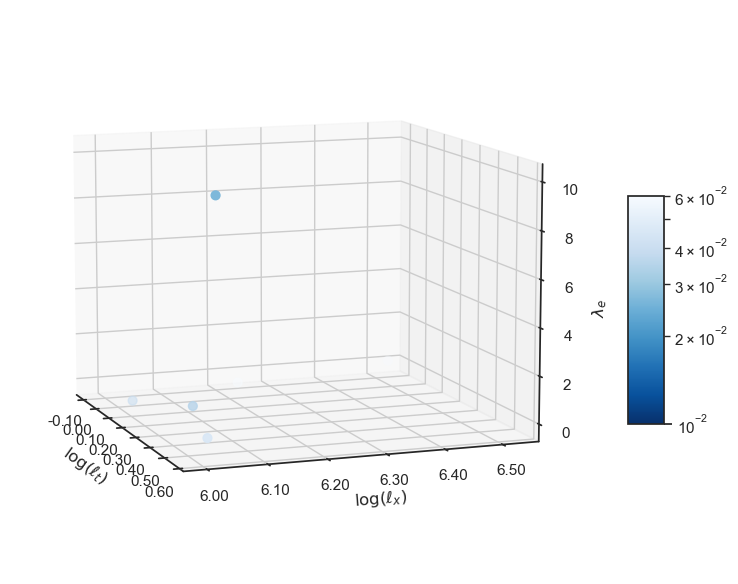

In [33]:
# Losses in validation set

fig, ax = plt.subplots(subplot_kw={"projection": "3d"}, figsize = (12,6))

x = np.log10(hp_plot_df[(hp_plot_df.dataset == 'validation') & (hp_plot_df.component == 'traveltime') ]['value'])
y = np.log10(hp_plot_df[(hp_plot_df.dataset == 'validation') & (hp_plot_df.component == 'flow') ]['value'])
z = hp_plot_df['lambda_equilibrium'].sort_values().unique()

c = hp_plot_df[['lambda_equilibrium', 'relative_gap']].sort_values(['lambda_equilibrium'])['relative_gap'].drop_duplicates().values

p = ax.scatter(x,y,z,
               c =c,
               # c =np.log10(hyperparameter_search_eq['loss_eq']),
               norm=colors.LogNorm(vmin=1e-2, vmax=6e-2),
               s=40, cmap='Blues_r')

cbar = plt.colorbar(p,
                    #ticks=[1e-3,1e-4,1e-5,1e-6,1e-7],
                    #ticks=np.linspace(start = 1e-6, stop = 1e-7,num = 5),
                    cax = fig.add_axes([0.78, 0.28, 0.03, 0.38]))

ax.set_xlabel(r'$\log(\ell_t)$')
ax.set_ylabel(r'$\log(\ell_x)$')
ax.set_zlabel(r'$\lambda_{e}$')

ax.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))

ax.view_init(elev=10., azim=-20, roll=0)

plt.tight_layout()

plt.show()

/var/folders/mg/t5yt0b_d1cg4ykytg0c22xcc0000gn/T/ipykernel_48378/103132812.py:32: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


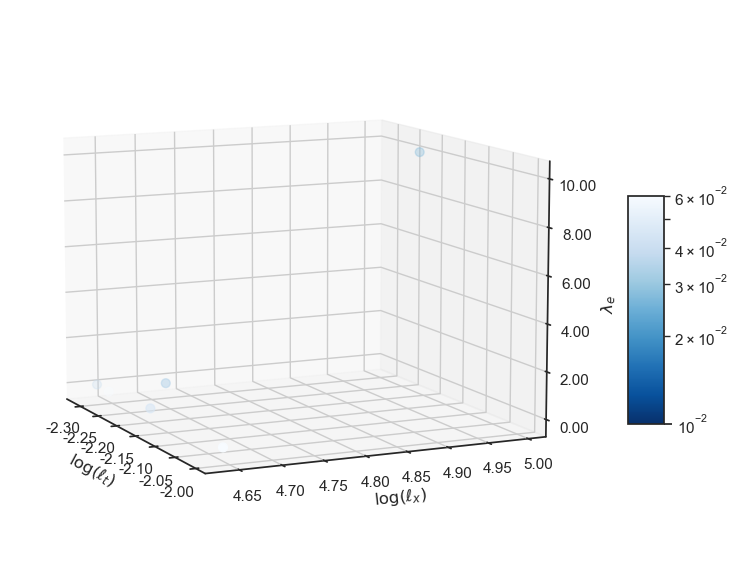

In [34]:
# Losses in training set

fig, ax = plt.subplots(subplot_kw={"projection": "3d"}, figsize = (12,6))

x = np.log10(hp_plot_df[(hp_plot_df.dataset == 'training') & (hp_plot_df.component == 'traveltime') ]['value'])
y = np.log10(hp_plot_df[(hp_plot_df.dataset == 'training') & (hp_plot_df.component == 'flow') ]['value'])
z = hp_plot_df['lambda_equilibrium'].sort_values().unique()

c = hp_plot_df[['lambda_equilibrium', 'relative_gap']].sort_values(['lambda_equilibrium'])['relative_gap'].drop_duplicates().values

p = ax.scatter(x,y,z,
               c =c,
               # c =np.log10(hyperparameter_search_eq['loss_eq']),
               norm=colors.LogNorm(vmin=1e-2, vmax=6e-2),
               s=40, cmap='Blues_r')

cbar = plt.colorbar(p,
                    #ticks=[1e-3,1e-4,1e-5,1e-6,1e-7],
                    #ticks=np.linspace(start = 1e-6, stop = 1e-7,num = 5),
                    cax = fig.add_axes([0.78, 0.28, 0.03, 0.38]))

ax.set_xlabel(r'$\log(\ell_t)$')
ax.set_ylabel(r'$\log(\ell_x)$')
ax.set_zlabel(r'$\lambda_{e}$')

ax.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.2f'))

ax.view_init(elev=10., azim=-25, roll=0)

plt.tight_layout()

plt.show()

### Estimation of TVGODLULPE with optimal hyperparameters

In [44]:
print('\ntvgodlulpe: Time specific utility and generation, and link specific parameters for performance functions')

# To report runtime
t0 = time.time()

def create_tvgodlulpe_model():
    return create_model(
        n_periods = n_periods,
        network = network,
        performance_function = create_mlp(network = network,
                                          poly_order = 4, pretrain = False, link_specific = False),
        historic_g= generated_trips,
        generation = True,
        generation_trainable = True,
        utility_trainable = True)

models['tvgodlulpe'], _ = create_tvgodlulpe_model()
models['tvgodlulpe'].key = 'tvgodlulpe'


tvgodlulpe: Time specific utility and generation, and link specific parameters for performance functions


In [45]:
# Use optimal hyperparameter and do not run equilibrium stage
_LOSS_WEIGHTS = optimal_weights
_LOSS_WEIGHTS

{'od': 0, 'traveltime': 1, 'flow': 1, 'equilibrium': 0.01}

In [46]:
train_results_dfs['tvgodlulpe'], val_results_dfs['tvgodlulpe'] = models['tvgodlulpe'].fit(
    XT_train, YT_train, XT_val, YT_val,
    node_data=nodes_df,
    optimizers= {'learning': tf.keras.optimizers.legacy.Adam(learning_rate=_LR['learning']),
                 'equilibrium': tf.keras.optimizers.legacy.Adam(learning_rate=_LR['equilibrium'])},
    batch_size=_BATCH_SIZE,
    loss_weights= _LOSS_WEIGHTS,
    loss_metric=_LOSS_METRIC,
    equilibrium_stage=_EQUILIBRIUM_STAGE,
    alternating_optimization=_ALTERNATING_OPTIMIZATION,
    pretrain_link_flows = True,
    threshold_relative_gap=_RELATIVE_GAP,
    epochs_print_interval=_EPOCHS_PRINT_INTERVAL,
    epochs=_EPOCHS)

print(f'runtime: {time.time()-t0:0.1f} [s]')

# Save model weights for prediction analyses
models['tvgodlulpe'].save_weights(models['tvgodlulpe']._filepath_weights)
print(f"\nModel weights were saved at '{models['tvgodlulpe']._filepath_weights}'")


Model training

Pretraining generation weights

period 0 -> p-values kappa: {'population': 0.0017, 'income': 0.5592, 'bus_stops': 0.341}
period 1 -> p-values kappa: {'population': 0.0017, 'income': 0.5592, 'bus_stops': 0.341}
period 2 -> p-values kappa: {'population': 0.0017, 'income': 0.5592, 'bus_stops': 0.341}
period 3 -> p-values kappa: {'population': 0.0017, 'income': 0.5592, 'bus_stops': 0.341}
period 4 -> p-values kappa: {'population': 0.0017, 'income': 0.5592, 'bus_stops': 0.341}
period 5 -> p-values kappa: {'population': 0.0017, 'income': 0.5592, 'bus_stops': 0.341}

Link flows and travel times were pretrained with single pass of traffic assignment
Benchmark metrics using historical mean in training data to make predictions in the validation set: 


    component    value metric
0        flow       57   mape
1  traveltime       55   mape
0        flow    6e+05    mse
1  traveltime    0.063    mse
0        flow   -0.057     r2
1  traveltime -0.00022     r2

hyperparameters los

# Forecasting

In [48]:
generation_factors = compute_generation_factors(period_column=XT_train[:, :, -1, None].numpy(),
                                                flow_column=YT_train[:,:,1, None].numpy(), reference_period=10)

print(generation_factors)

n_periods = len(np.unique(XT_train[:, :, -1].numpy().flatten()))

growth_factor = 7.9/6.6

generated_trips = growth_factor*generation_factors.values[:,np.newaxis]*compute_generated_trips(
    q = network.q.flatten()[np.newaxis,:], ods= network.ods, n_nodes = len(network.nodes))

period_id
0.0    0.823474
1.0    0.946993
2.0    0.825935
3.0    0.999961
4.0    1.000000
5.0    0.886333
Name: flow, dtype: float32


In [49]:
# Create model for inference
inference_model, _ = create_tvgodlulpe_model()
inference_model.build()
inference_model.load_weights(models['tvgodlulpe']._filepath_weights)

In [50]:
# Make prediction on 2020, the validation set, without computing equilibrium
_ = inference_model.predict(XT_val,
                            node_data=nodes_df,
                            loss_metric=_LOSS_METRIC,
                            batch_size= _BATCH_SIZE,
                            optimizer= tf.keras.optimizers.legacy.Adam(learning_rate=_LR['learning']),
                            pretrain_link_flows = False,
                            loss_weights= optimal_weights,
                            threshold_relative_gap=float('inf'),  # _RELATIVE_GAP,
                            epochs_print_interval=_EPOCHS_PRINT_INTERVAL,
                            epochs=100)


Computing gradient based equilibrium

Model training

hyperparameters loss function: {'od': 0, 'traveltime': 1, 'flow': 1, 'equilibrium': 0.01}

number of periods: 6, batch size: 1, threshold relative gap: inf
training set -> timepoints: 78, obs [t x]: nan, coverage [t x]: nan

0/100: train mse=3e+02, theta = [-3.023 -3.062  0.    -5.225 -0.048 -4.367], avg rr = 1.01, avg theta fixed effect = -0.0088, loss prop od=2.5e+03, total trips=[6.63e+04 6.63e+04 6.63e+04 6.63e+04 6.63e+04 6.63e+04], polynomial weights: [1.0e-01 1.3e-01 1.4e-01 1.5e-01], kappa = [133.407  28.704 -39.104], lambda eq=0.01, relative gap=0.1, train equilibrium loss=5.9e+04, time: 1.4

Relative gap threshold of inf was achieved in equilibrium stage


In [51]:
with pd.option_context('display.float_format', '{:0.3g}'.format):
    print('\n')
    validation_metrics = inference_model.compute_loss_metrics(metrics = {'mape': mape, 'mse': mse, 'r2': r2_score}, X = XT_val, Y = YT_val)
    print(validation_metrics)



     component    value metric
0         flow     19.3   mape
1   traveltime     12.7   mape
2  equilibrium 5.57e+15   mape
0         flow 1.57e+05    mse
1   traveltime  0.00558    mse
2  equilibrium 5.38e+04    mse
0         flow    0.734     r2
1   traveltime    0.908     r2
2  equilibrium    0.907     r2


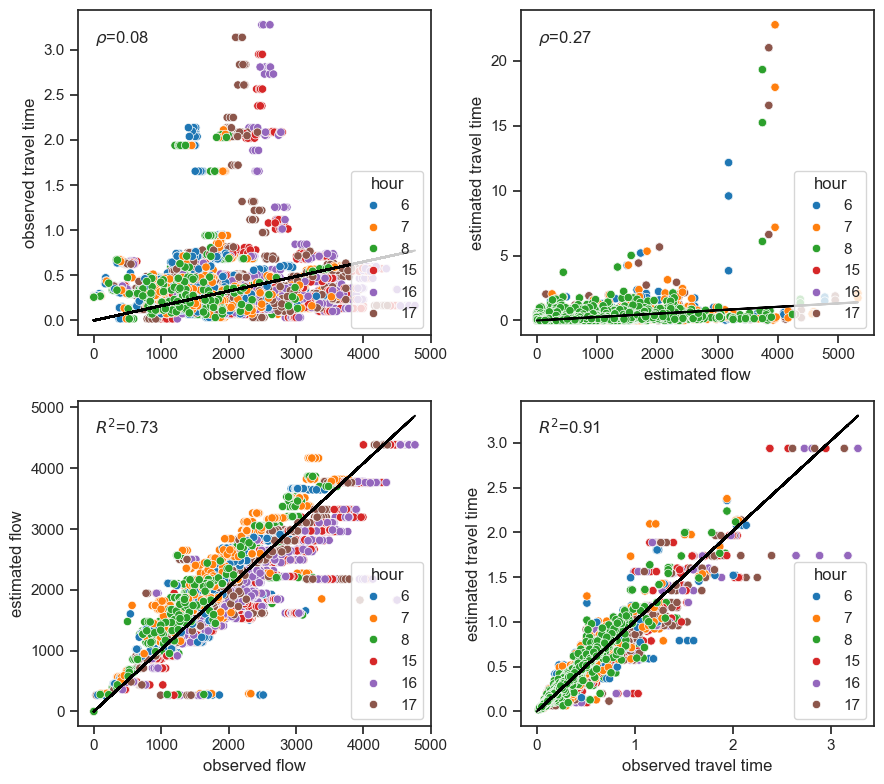

In [52]:
fig, axs = plot_flow_vs_traveltime(model = inference_model,
                        observed_traveltime=inference_model.mask_observed_traveltime(YT_val[:, :, 0]),
                        observed_flow= inference_model.mask_observed_flow(YT_val[:,:,1]),
                        # scatter_kws={"color": sns.color_palette("deep")[0], 's':4, 'alpha': 1}, line_kws={"color": "black"},
                        period_col = pd.DataFrame({'period': list(XT_val[:, :, -1].numpy().astype(int).flatten())})['period'].map(dict(zip(period_keys.period_id, period_keys.hour))).values.flatten(),
                        hour_label=True,
                        all_metrics = False
                        )

for ax in axs.reshape(-1):
    ax.legend(loc='lower right', title = 'hour')

plt.savefig('output/figures/results/fresno-scatter-flow-traveltime-outofsample-tvgodlulpe-without-equilibrium.png')

plt.show()

## Comparison against data-driven top performing data-driven benchmark

In [206]:
# Link-level spatial information
links_gdf['link_key'] = pd.Categorical(links_gdf['key'].apply(ast.literal_eval), list(network.links_dict.keys()))

# Create dataframe with data collected in 2020 during peak hours only
model_df = df[(df.hour.isin([6,7,8, 15,16,17])) & (df['year']==2020)].sort_values(['period','link_key'])
# links_gdf = links_gdf.sort_values(['link_key'])

# Build dataset witg data collected between 4-5pm in the first Tuesdays of Oct 2019 and 2020
benchmark_df = df[(df.hour == 16) & df['date'].isin(['2019-10-01', '2020-10-06'])].sort_values(['period','link_key'])

fig_speed, fig_flow, legend = plot_congestion_maps(model=inference_model, model_df=model_df, benchmark_df = benchmark_df,
                     gdf=links_gdf.sort_values(['link_key']), features=_FEATURES_Z, cmap = 'viridis')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


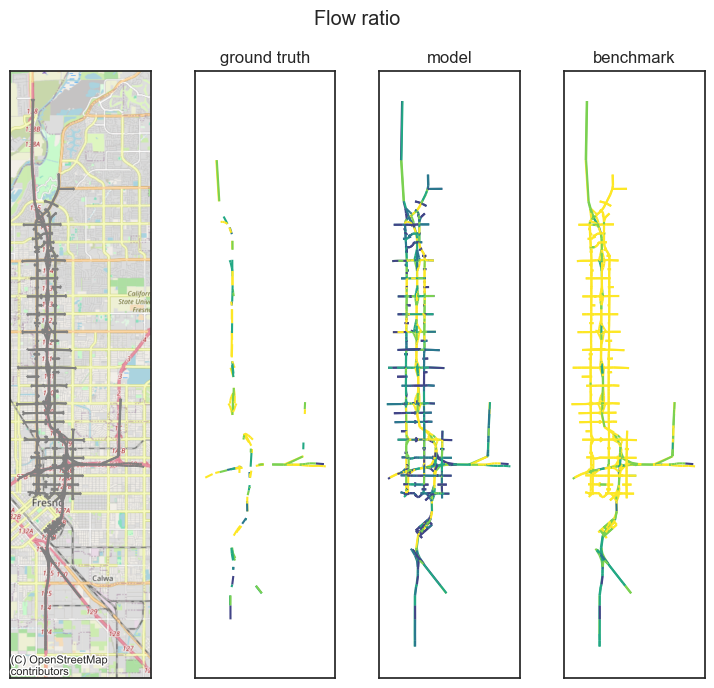

In [207]:
fig_flow

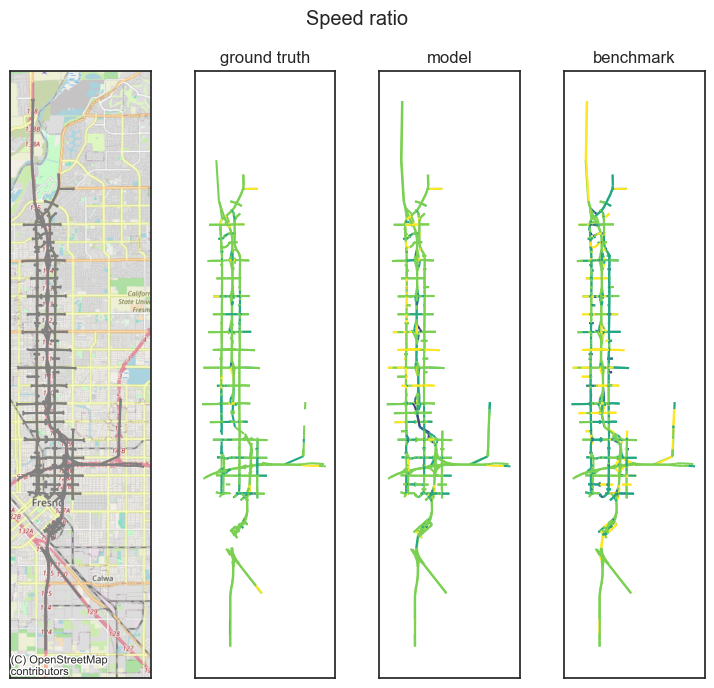

In [208]:
fig_speed

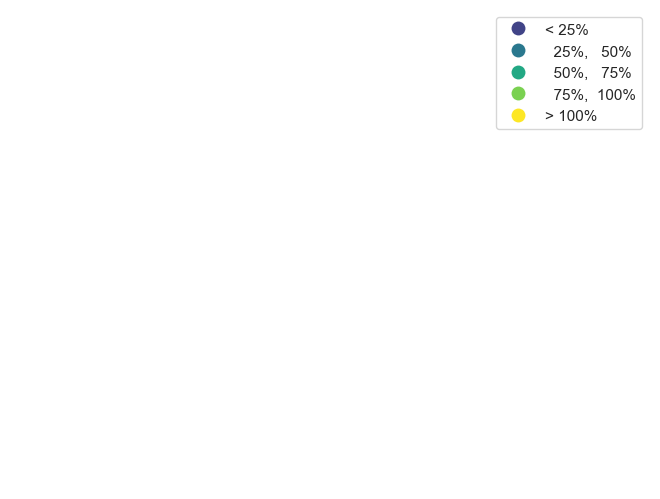

In [209]:
legend



## Global runtime

In [53]:
print(f'runtime: {time.time()-t0_global:0.1f} [s]')

runtime: 92306.2 [s]
